In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time

path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


## Data set import

In [2]:
class loaded:
    def __init__(self,frm=0,t=20):
        data = np.load(datapath+"X_texture.npz") #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+"y_texture.npz") #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys={}
        self.files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(self.files):
            self.keys[i]=name
        self.keys={14: 'wool', 23: 'jeans', 20: 'LacedMatt', 22: 'Gfoam', 27: 'bubble', 16: 'Efoam', 21: 'cotton', 11: 'Flat', 24: 'felt', 26: 'Ffoam'}
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,frm:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.AugmentedX=shuffled_data
        self.Augmentedy=shuffled_labels
        del self.X
        del self.y
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

"""
plt.imshow(data.AugmentedX[0].reshape((5*110,120)))
plt.show()
"""


'\nplt.imshow(data.AugmentedX[0].reshape((5*110,120)))\nplt.show()\n'

In [3]:
def genData(frm,to):
    torch.cuda.empty_cache()
    data=loaded(frm=frm,t=to)
    data.applySobel()
    data.augment()
    n=int(len(data.AugmentedX)*0.6)
    # Example: if train_labels are strings, use LabelEncoder to convert them to integers
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(data.Augmentedy[0:n])
    one_hot_labels = torch.nn.functional.one_hot(torch.tensor(train_labels_encoded), num_classes=len(np.unique(train_labels_encoded)))
    print("Memory left",round(torch.cuda.mem_get_info()[1]/ 1024 / 1024/ 1024,2),"GB")
    x_data=data.AugmentedX[0:n].reshape((len(data.AugmentedX[0:n]),1,abs(frm-to)*110,120))
    x_data=(x_data-np.mean(x_data))/(np.max(x_data)-np.min(x_data))
    train_images_tensor = torch.tensor(x_data, dtype=torch.float32).to(device)
    print("Using",round(getsizeof(x_data)/ 1024 / 1024/ 1024,2),"GB")
    train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)

    # Create a TensorDataset
    dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    # Split the dataset into training and testing sets (e.g., 80% training, 20% testing)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoader for training and testing sets
    train_loader = DataLoader(dataset=train_dataset, batch_size=40, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=40,shuffle=False)

    print(train_images_tensor.shape)
    print(train_labels_tensor.shape)
    unique={}
    for i in range(len(train_labels_encoded)):
        if unique.get(train_labels_encoded[i],False)==False:
            unique[train_labels_encoded[i]]=data.Augmentedy[0:n][i]
    return train_loader,test_loader,unique

## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self,input_height, input_width):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        height = input_height
        width = input_width
        
        height = height // 2  # after first pooling
        width = width // 2
        height = height // 2  # after second pooling
        width = width // 2
        
        # Number of output features from conv layers (channels * height * width)
        self.flatten_size = 64 * height * width
        
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 9)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train

In [5]:
# Define the Loss Function and Optimizer
def run(train_loader,frm,to):
    model = SimpleCNN(abs(frm-to)*110,120).to(device)#.half()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.005)

    # Train the Model
    num_epochs = 100
    clip_value = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss :.4f}')
    print('Finished Training')
    return model

In [6]:
def calc(model,data_loader):
        correct=0
        summed=0.1
        for i, (inputs, labels) in enumerate(data_loader):
            outputs = model(inputs)
            a=torch.argmax(outputs,axis=1)==torch.argmax(labels,axis=1)

            summed+=len(inputs)
            correct+=len(a[a==1])
        print("Accuracy:",(correct/summed)*100,"%")
        return correct/summed


In [ ]:
test_scores=np.zeros((10,14,3))
train_scores=np.zeros((10,14,3))
t_averages=np.zeros((10*14*3))

#test_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/test_scores.npy")
#train_scores=np.load("C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/saves/train_scores.npy")
c=0
for i in range(1,10): #loop through frm dimention
    for j in range(i+1,15): #loop though to dimention
        print(">>>>",i,j,"\nMax:",np.max(test_scores)*100,"%","\nEstimated time left:",(np.average(t_averages[t_averages!=0])*len(t_averages[t_averages==0]))/60,"minutes")
        for trial in range(3):
            t=time.time()
            torch.cuda.empty_cache()
            train_loader,test_loader,__=genData(i,j)
            model=run(train_loader,i,j)
            test_scores[i][j-1][trial]=calc(model,test_loader)
            train_scores[i][j-1][trial]=calc(model,train_loader)
            torch.cuda.empty_cache()
            del train_loader
            del test_loader
            del model
            t2=time.time()
            t_averages[c]=t2-t
            c+=1
        clear_output(wait=True)
        np.save(path+"saves/test_scores",test_scores)
        np.save(path+"saves/train_scores",train_scores)




### Look at performance

In [7]:
try:
    torch.cuda.empty_cache()
    train_loader,test_loader,unique=genData(0,4)
    model=run(train_loader,0,4)
    print(calc(model,test_loader))
    print(calc(model,train_loader))
except MemoryError as e:
    try:
        del train_loader
        del test_loader
        del model
    except: 
        pass
    

Dataset size: 4800 
Window size: 20 
Image: (110, 120)
Memory needed: 1.18 GB
Dataset size: 14400 
Window size: 4 
Image: (110, 120)
Memory needed: 0.71 GB
Memory left 1.93 GB
Using 1.13 GB
torch.Size([2880, 1, 440, 120])
torch.Size([2880, 9])


/tmp/ipykernel_4355/552130107.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [58/58], Loss: 125.5771
Epoch [11/100], Step [58/58], Loss: 60.3942
Epoch [21/100], Step [58/58], Loss: 26.2105
Epoch [31/100], Step [58/58], Loss: 14.6367
Epoch [41/100], Step [58/58], Loss: 10.6667
Epoch [51/100], Step [58/58], Loss: 7.3351
Epoch [61/100], Step [58/58], Loss: 4.6500
Epoch [71/100], Step [58/58], Loss: 4.2379
Epoch [81/100], Step [58/58], Loss: 3.4023
Epoch [91/100], Step [58/58], Loss: 2.6538
Finished Training
Accuracy: 99.80906092692241 %
0.9980906092692241
Accuracy: 99.82205633436048 %
0.9982205633436049


(576,) (576,)


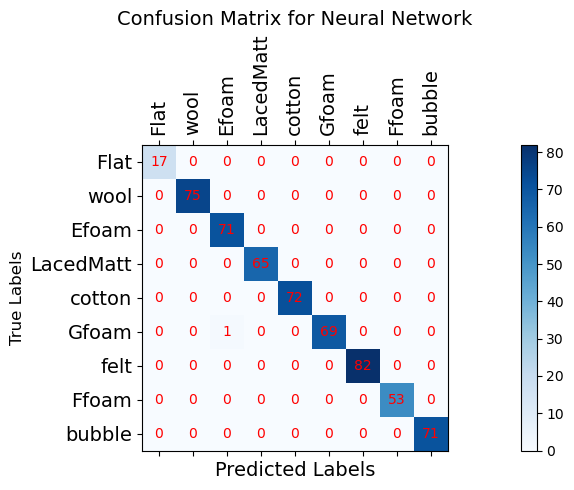

In [8]:
preds=None
real=None
keys={14: 'wool', 23: 'jeans', 20: 'LacedMatt', 22: 'Gfoam', 27: 'bubble', 16: 'Efoam', 21: 'cotton', 11: 'Flat', 24: 'felt', 26: 'Ffoam'}

for i, (inputs, labels) in enumerate(test_loader):
    outputs = model(inputs)
    a=torch.argmax(outputs.detach(),axis=1)
    if type(preds)==type(None):
        preds=a.numpy().copy()
        real=np.argmax(labels.numpy().copy(),axis=1)
    else:
        preds=np.concatenate([preds,a.numpy().copy()])
        real=np.concatenate([real,np.argmax(labels.numpy().copy(),axis=1)])


def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    un=np.unique(real)
    for t, p in zip(true_labels, pred_labels):
        matrix[t, p] += 1
    return matrix

print(real.shape,preds.shape)
# Combine all predictions
predictions = [preds]
model_names = ['Neural Network']
num_classes = len(np.unique(real))
un=np.unique(real)
indices = np.arange(num_classes)
# Plotting confusion matrices for each model
fig, axes = plt.subplots(1, len(predictions), figsize=(15, 5))

for i, preds in enumerate(predictions):
    cm = compute_confusion_matrix(real, preds, num_classes=len(np.unique(real)))
    
    ax = axes[i] if len(predictions) > 1 else axes
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax, ax=ax)
    
    for (j, k), value in np.ndenumerate(cm):
        ax.text(k, j, f'{value}', ha='center', va='center', color='red')
    ax.set_title(f'Confusion Matrix for {model_names[i]}',fontsize=14)
    ax.set_xlabel('Predicted Labels',fontsize=14)
    ax.set_xticks(indices)
    ax.set_xticklabels([keys[unique[j]] for j in range(num_classes)],rotation=90,fontsize=14)
    ax.set_ylabel('True Labels',fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels([keys[unique[j]] for j in range(num_classes)],rotation=0,fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
#perform on unseen pressures

# Vis

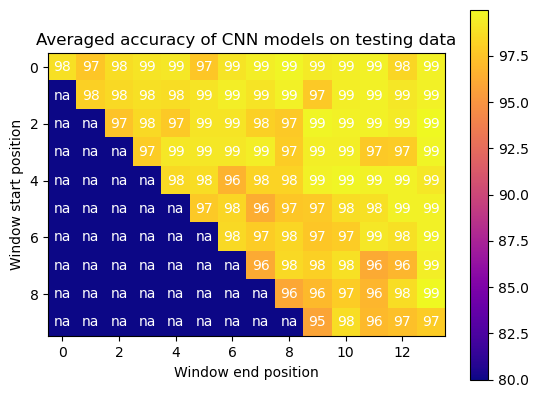

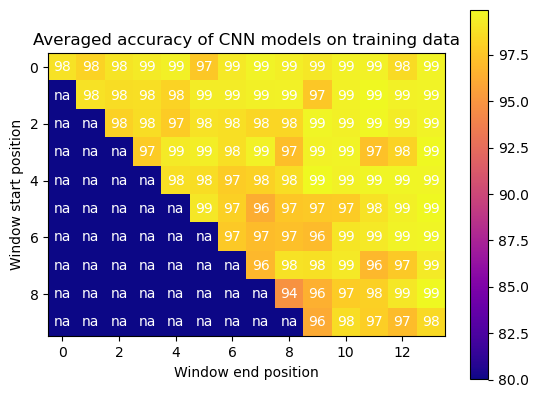

In [48]:
test=np.load(path+"saves/test_scores.npy")
train=np.load(path+"saves/train_scores.npy")

test=np.max(test,axis=2)*100
"""test=(test-np.min(test))/(np.max(test)-np.min(test))
test*=255"""
test[test==0]=80
plt.imshow(test,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(test.shape[0]):
    for j in range(test.shape[1]):
        num=int(test[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')

plt.title("Averaged accuracy of CNN models on testing data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()



train=np.max(train,axis=2)*100
train[train==0]=80
plt.imshow(train,cmap="plasma")
# Loop over data dimensions and create text annotations.
for i in range(train.shape[0]):
    for j in range(train.shape[1]):
        num=int(train[i, j])
        if num==80: num="na"
        plt.text(j, i, num, ha='center', va='center', color='white')
plt.title("Averaged accuracy of CNN models on training data")
plt.xlabel("Window end position")
plt.ylabel("Window start position")
plt.colorbar()
plt.show()